In [2]:
# Imports, as always...
import os
import re
import csv
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn as nn
from torch.utils.data import DataLoader

from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch.losses import DiceLoss

from tqdm.notebook import tqdm

from data_handling import ISICDataset

from datetime import datetime

# Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

# Beautification.
sns.set_context('paper')
sns.set_style('darkgrid')
sns.set_palette('Spectral')

print(f'CUDA is available for use with PyTorch: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    torch.set_default_device('cuda')

print(f'Installed Python version:  {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')
print(f'Installed PyTorch version: {torch.__version__}')

# Helper function to send a tensor/model/etc. to the CPU/GPU accordingly.
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()
    
# Helper function for closing figures.
def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()
        
# Get the current data and time as a string.
date_string = datetime.now().strftime('%Y-%m-%d-(%H-%M-%S)')

print(f'Date: {date_string}')

CUDA is available for use with PyTorch: True
Installed Python version:  3.8.18
Installed PyTorch version: 2.1.2+cu121
Date: 2024-03-13-(15-01-50)


## Data Handling

In [16]:
# Change this as necessary. Unzip all downloaded data into this directory, keeping default naming.
data_directory = './data/ISIC2018/'

# Define the train dataset.
train_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Training_Input',
    target_path='ISIC2018_Task1_Training_GroundTruth',
    transform=True,
    image_width=128, image_height=128,
)

# Define the validate dataset.
val_dataset = ISICDataset(
    root_path=data_directory,
    input_path='ISIC2018_Task1-2_Validation_Input',
    target_path='ISIC2018_Task1_Validation_GroundTruth',
    transform=True,
    image_width=128, image_height=128
)

# Package into data loaders.
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

## Segmentation, and Whatnot

In [19]:
# Demonstrate model's segmentation.
def side_by_side_model_segmentation(model, example_sample, cmap='bone'):
    # Break apart the sample and move to device.
    example_input, example_target = example_sample
    example_input = example_input.reshape(1, 3, 128, 128).to('cuda')
    example_target = example_target.to('cuda')
    example_output, _ = model(example_input, example_target)
    
    # Show them.
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'wspace': 0, 'hspace': 0})
    ax1.imshow(example_input[0].detach().cpu().permute(1, 2, 0))
    ax2.imshow(example_output[0].detach().cpu().permute(1, 2, 0), cmap=cmap)
    ax3.imshow(example_target[0].detach().cpu(), cmap=cmap)
    
    # Memory saving.
    del example_sample
    del example_input
    del example_target
    del example_output
    
    # Beautify.
    ax1.axis('off')
    ax1.axis('tight')
    ax1.axis('image')
    ax2.axis('off')
    ax2.axis('tight')
    ax2.axis('image')
    ax3.axis('off')
    ax3.axis('tight')
    ax3.axis('image')
    
    ax1.set_title('Corrupted Input')
    ax2.set_title('Predicted Mask')
    ax3.set_title('True Mask')

In [14]:
# Define the model.
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        
        self.model = UnetPlusPlus(
            encoder_name='timm-efficientnet-b0',
            encoder_weights='imagenet',
            in_channels=3,
            classes=1,
            activation=None
        )
    
    def forward(self, x, y_true):
        y_pred = self.model(x)
        
        if y_true is not None:
            loss = DiceLoss(mode='binary')(y_pred, y_true)
            return y_pred, loss
        
        return y_pred
    
model = SegmentationModel()
model = model.to('cuda')

Training:   0%|          | 0/20 [00:00<?, ?it/s]

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 000: train loss - 0.1091 | val loss - 0.1087
Model saved.


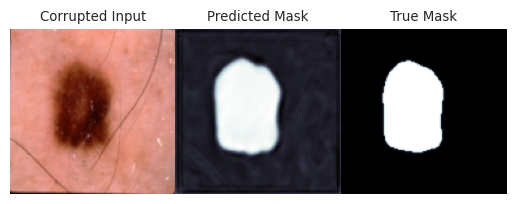

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 001: train loss - 0.0995 | val loss - 0.1162


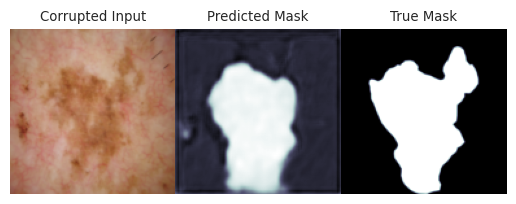

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 002: train loss - 0.0944 | val loss - 0.1086
Model saved.


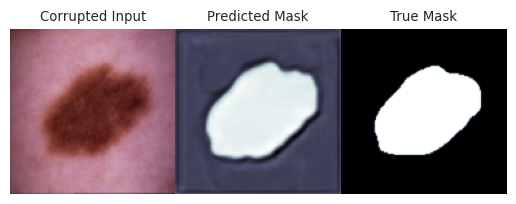

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 003: train loss - 0.0870 | val loss - 0.1052
Model saved.


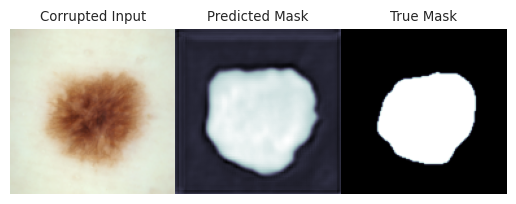

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 004: train loss - 0.0867 | val loss - 0.1022
Model saved.


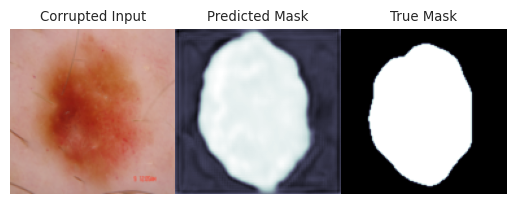

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 005: train loss - 0.0789 | val loss - 0.1188


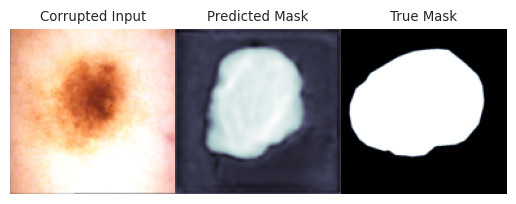

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

In-epoch validation:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 006: train loss - 0.0738 | val loss - 0.1108


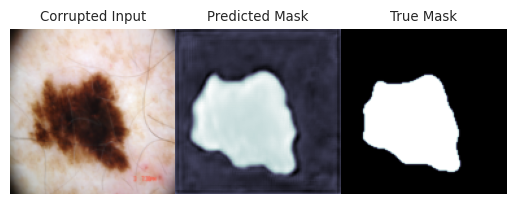

In-epoch training:   0%|          | 0/163 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [31]:
# Train one epoch.
def train(model, train_loader, optimiser):
    model.train()
    train_loss = .0
    
    for inputs, targets in tqdm(train_loader, desc='In-epoch training'):
        # Move to device.
        inputs = inputs.to('cuda')
        targets = targets.to('cuda')
        
        optimiser.zero_grad()
        y_pred, loss = model(inputs, targets)
        loss.backward()
        optimiser.step()
        
        train_loss += loss.item()
        
    return train_loss / len(train_loader)

# Test the model.
def test(model, val_loader):
    model.eval()
    val_loss = .0
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc='In-epoch validation'):
            # Move to device.
            inputs = inputs.to('cuda')
            targets = targets.to('cuda')
            
            _, loss = model(inputs, targets)
            val_loss += loss.item()
            
        return val_loss / len(val_loader)
    
# Optimiser and scheduler.
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=1, gamma=.7)

best_val_loss = np.inf
n_epochs = 20
os.makedirs(f'./models/unet/saves/{date_string}', exist_ok=True) 
for epoch_idx in tqdm(range(n_epochs), desc='Training'):
    train_loss = train(model, train_dataloader, optimiser)
    val_loss = test(model, val_dataloader)
    
    print(f'Epoch {epoch_idx:03d}: train loss - {train_loss:.4f} | val loss - {val_loss:.4f}')
    
    # Write stats to file.
    with open(f'./models/unet/saves/{date_string}/stats.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([epoch_idx, train_loss, val_loss])
    
    # Save the model if it's the best yet.
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), f'./models/unet/saves/{date_string}/model-state-dict.pt')
        best_val_loss = val_loss
        print('Model saved.')
        
    # Let's have a little looksie.
    side_by_side_model_segmentation(model, val_dataset[np.random.randint(0, len(val_dataset)-1)])
    plt.show()